In [19]:
import os
import pickle
from importlib import reload

import numpy as np
import sciplots as plots
from astropy.io import fits
from astropy.cosmology import WMAP9
from astropy.units.core import Unit
from astropy.constants import c as c_light
from astropy.constants import G as G_newton
from scipy.ndimage import map_coordinates
from scipy.stats import gaussian_kde

In [3]:
def convert_units(x, target):
    """Convert or attach units to a variable.

    Parameters
    ----------
    x : float
        Quantity to convert.
    target : str
        Target units given as an acceptable astropy.units string (e.g. 'km').

    Raises
    ------
    Exception
        If the conversion fails.

    Examples
    --------
    >>> conv(5, 'kpc')
    <Quantity 5. kpc>

    >>> x = 4e14
    >>> x = conv(x, 'solMass')
    >>> conv(x, 'kg')
    <Quantity 7.95390166e+44 kg>

    """
    try:
        x = x.to(Unit(target))
    except AttributeError:
        x = x * Unit(target)
    except Exception as e:
        raise

    return x


def sigma_critical(zl, zs, cosmology):
    """Critical surface mass density between a lens and source galaxy(-ies).

    Sigma_critical = [c^2 / (4 * pi * G)] * D_os / (D_ol * D_ls)

    Angular diameter distances D are calculated in a universe specified by
    an instance of astropy.cosmology.core.Cosmology.

    Parameters
    ----------
    zl : float
        Redshift of the lens.
    zs : array_like
        Redshift(s) of the source galaxies.
    cosmology : astropy.cosmology.core.Cosmology
        Cosmological model.

    Returns
    -------
    astropy.units.quantity.Quantity
        Critical surface mass density between a lens (i.e. cluster or DM halo)
        and each source redshift in units of solar masses per square parsec.
        For sources at the redshift of the halo and below, Sigma_critical is
        set to np.inf.
    """
    # Ensure vectorization
    zs = np.atleast_1d(zs).astype(float)
    assert (zs >= 0).all(), "Redshifts must be positive."
    result = np.zeros_like(zs)

    # Compute distances
    d_ol = cosmology.angular_diameter_distance(zl)
    d_os = cosmology.angular_diameter_distance(zs)
    d_ls = cosmology.angular_diameter_distance_z1z2(zl, zs)

    # Avoid division by zero
    d_ls[d_ls == 0] = np.inf

    # Compute Sigma_crit
    factor = np.power(c_light, 2) / (4 * np.pi * G_newton)
    result = factor * d_os / (d_ol * d_ls)

    # Sources at lower z than the halo are not lensed
    result[result <= 0] = np.inf
    return convert_units(result, "solMass / pc2")


def ks93inv(kE, kB):
    """Direct inversion of weak-lensing convergence to shear.

    This function provides the inverse of the Kaiser & Squires (1993) mass
    mapping algorithm, namely the shear is recovered from input E-mode and
    B-mode convergence maps.

    Parameters
    ----------
    kE, kB : array_like
        2D input arrays corresponding to the E-mode and B-mode (i.e., real and
        imaginary) components of convergence.

    Returns
    -------
    g1, g2 : tuple of numpy arrays
        Maps of the two components of shear.

    Raises
    ------
    AssertionError
        For input arrays of different sizes.

    See Also
    --------
    ks93
        For the forward operation (shear to convergence).

    """
    # Check consistency of input maps
    assert kE.shape == kB.shape

    # Compute Fourier space grids
    k1, k2 = np.meshgrid(np.fft.fftfreq(kE.shape[-1]), np.fft.fftfreq(kE.shape[-2]))

    # Compute Fourier transforms of kE and kB
    kEhat = np.fft.fft2(kE)
    kBhat = np.fft.fft2(kB)

    # Apply Fourier space inversion operator
    p1 = k1 * k1 - k2 * k2
    p2 = 2 * k1 * k2
    k2 = k1 * k1 + k2 * k2
    k2[..., 0, 0] = 1  # avoid division by 0
    g1hat = (p1 * kEhat - p2 * kBhat) / k2
    g2hat = (p2 * kEhat + p1 * kBhat) / k2

    # Transform back to pixel space
    g1 = np.fft.ifft2(g1hat).real
    g2 = np.fft.ifft2(g2hat).real

    return g1, g2

In [4]:
with open('../data/bahamas_cdm.pkl', 'rb') as file:
    labels, images = pickle.load(file)

In [5]:
sigma_crits = sigma_critical(np.where(labels['redshift'] == 0, np.unique(labels['redshift'])[1] / 2, labels['redshift']), 1, WMAP9)
peaks = labels['norms'][:, 0] * Unit('solMass') / (Unit('Mpc') ** 2)
shear_maps = np.array(ks93inv((images[:, 0] * peaks[:, np.newaxis, np.newaxis] / sigma_crits[:, np.newaxis, np.newaxis]), np.zeros_like(images[:, 0]))).swapaxes(0, 1)
shear_maps.shape

(3600, 2, 100, 100)

In [32]:
phis = np.arctan2(shear_maps[:, 1], shear_maps[:, 0]) / 2
amps = np.sqrt(shear_maps[:, 0] ** 2 + shear_maps[:, 1] ** 2)
shear_maps_car = np.stack([amps * np.cos(phis), amps * np.sin(phis)], axis=1)
shear_maps_car.shape

(3600, 2, 100, 100)

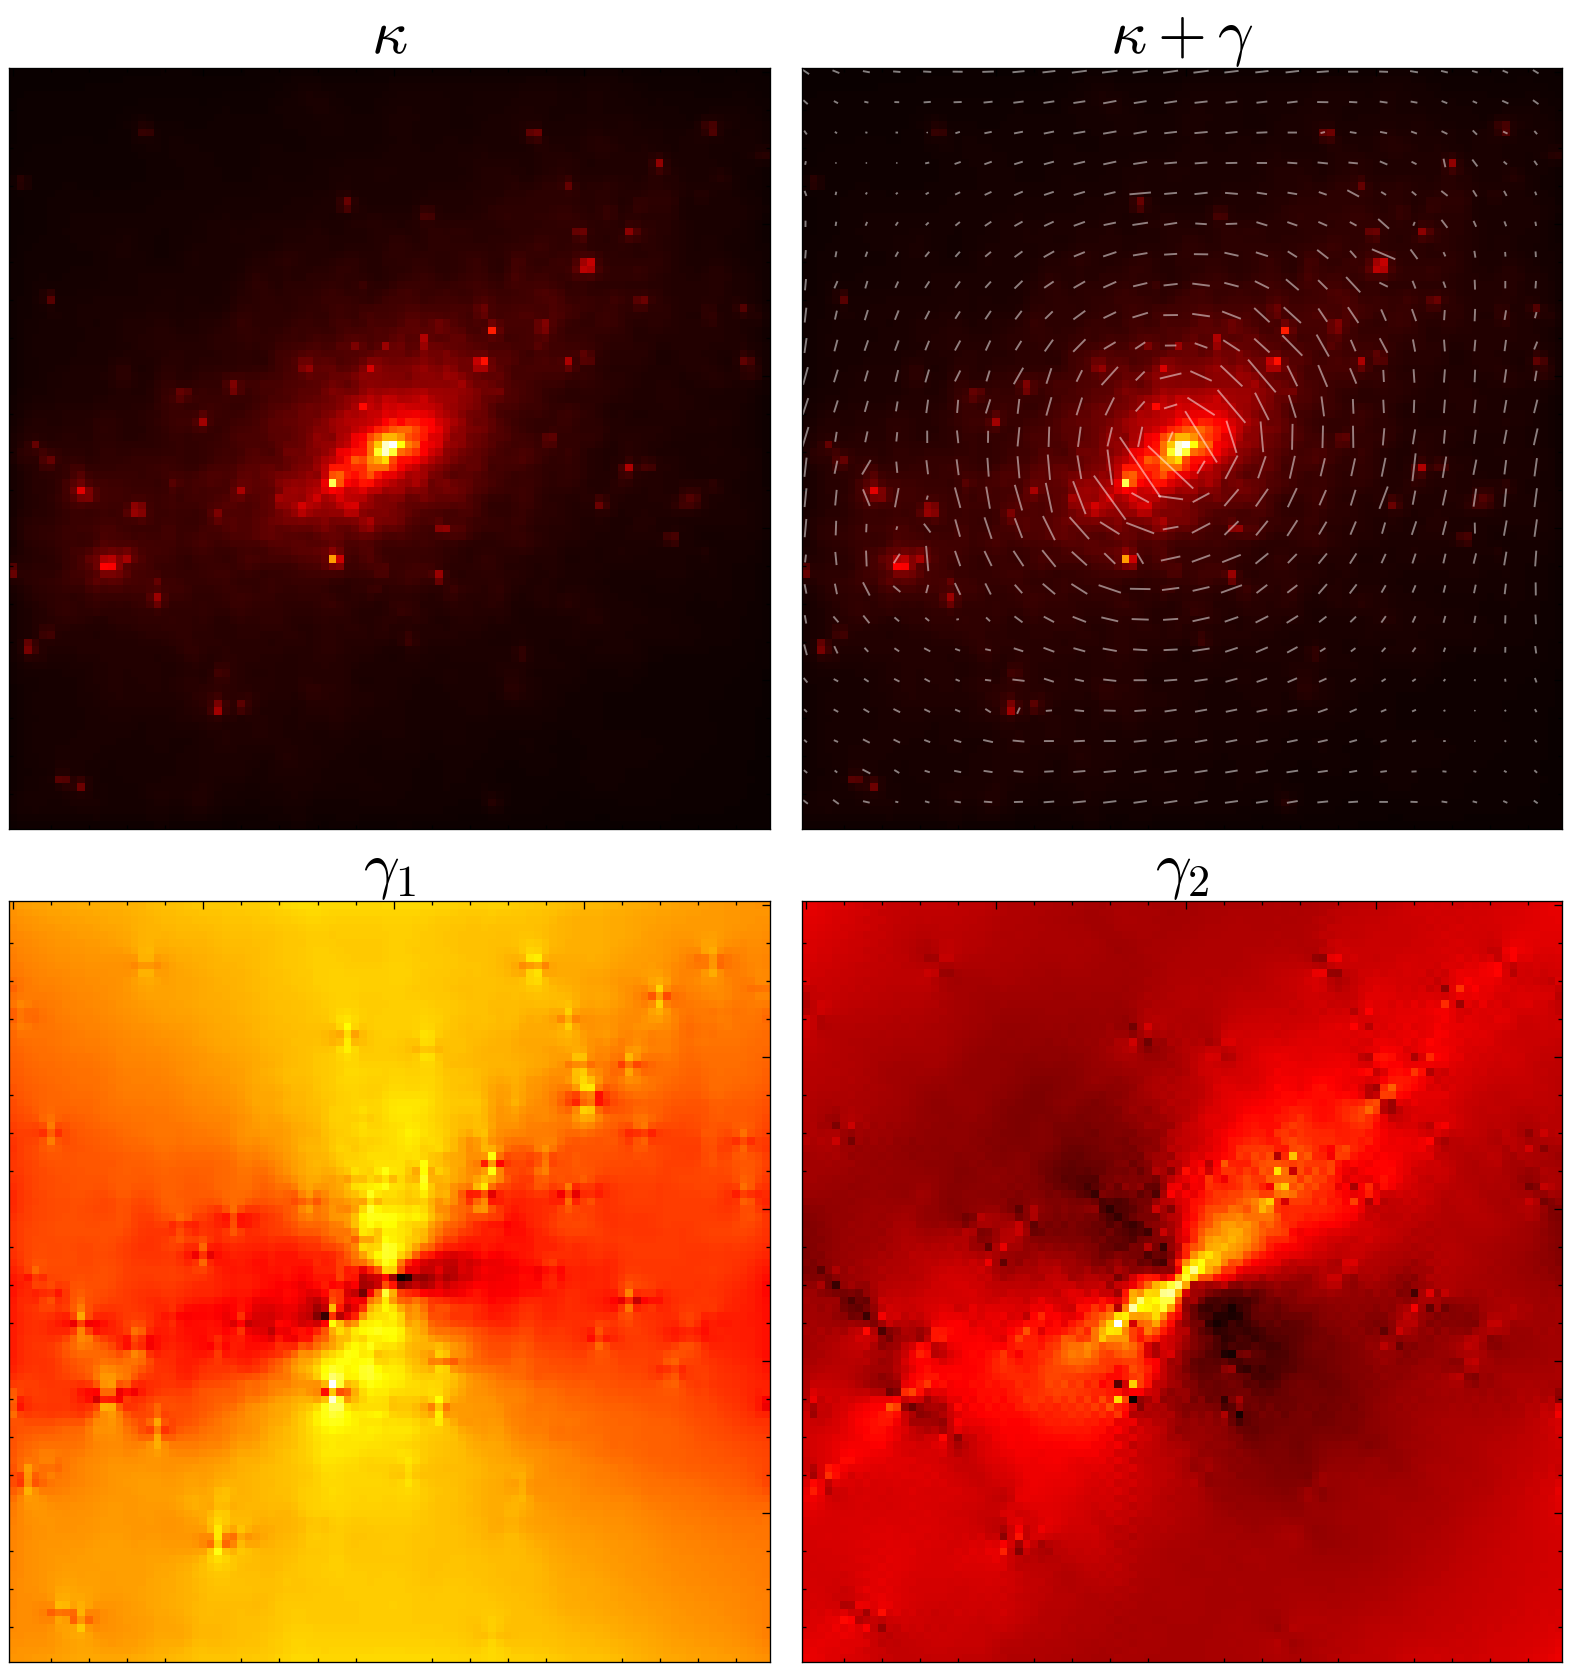

In [33]:
idx = -3
step = 4
plot = plots.PlotImages(
    [images[idx, 0], images[idx, 0], *shear_maps[idx]],
    titles=[r'$\kappa$', r'$\kappa + \gamma$', r'$\gamma_1$', r'$\gamma_2$'],
    fig_size=(16, 17),
)
plot.axes[1].quiver(
    *np.meshgrid(np.arange(0, shear_maps.shape[-2], step), np.arange(0, shear_maps.shape[-1], step)),
    *shear_maps_car[idx, :, ::step, ::step] / np.max(shear_maps_car[idx]),
    color='w',
    angles='xy',
    scale=10,
    headlength=0,
    headaxislength=0,
    headwidth=0,
    alpha=0.5,
    width=0.0025,
    pivot='mid',
)

In [ ]:
sim = 'bahamas_1'
data_dir = '../data/'

with open(os.path.join(data_dir, sim + '.pkl'), 'rb') as file:
    labels, images = pickle.load(file)

sigma_crits = sigma_critical(np.where(labels['redshift'] == 0, np.unique(labels['redshift'])[1] / 2, labels['redshift']), 1, WMAP9)
peaks = labels['norms'][:, 0] * Unit('solMass') / (Unit('Mpc') ** 2)
shear_maps = np.array(ks93inv((images[:, 0] * peaks[:, np.newaxis, np.newaxis] / sigma_crits[:, np.newaxis, np.newaxis]), np.zeros_like(images[:, 0]))).swapaxes(0, 1)
labels['norms'] = np.max(shear_maps, axis=(-3, -2, -1))
shear_maps /= labels['norms'][:, np.newaxis, np.newaxis, np.newaxis]

with open(os.path.join(data_dir, f'{sim}_shear.pkl'), 'wb') as file:
    pickle.dump((labels, shear_maps), file)

In [6]:
real_redshifts = np.array([0.1825, 0.293, 0.19, 0.306, 0.2312, 0.295, 0.2924, 0.1827, 0.2812, 0.341, 0.352, 0.40522, 0.356, 0.54, 0.272, 0.48, 0.2226, 0.702, 0.678, 0.46, 0.373, 0.23, 0.231, 0.2287, 0.2836, 0.22, 0.2192, 0.2534, 0.19276, 0.173, 0.425, 0.149, 0.153, 0.1464, 0.2245, 0.396, 0.1532366, 0.39, 0.38279])

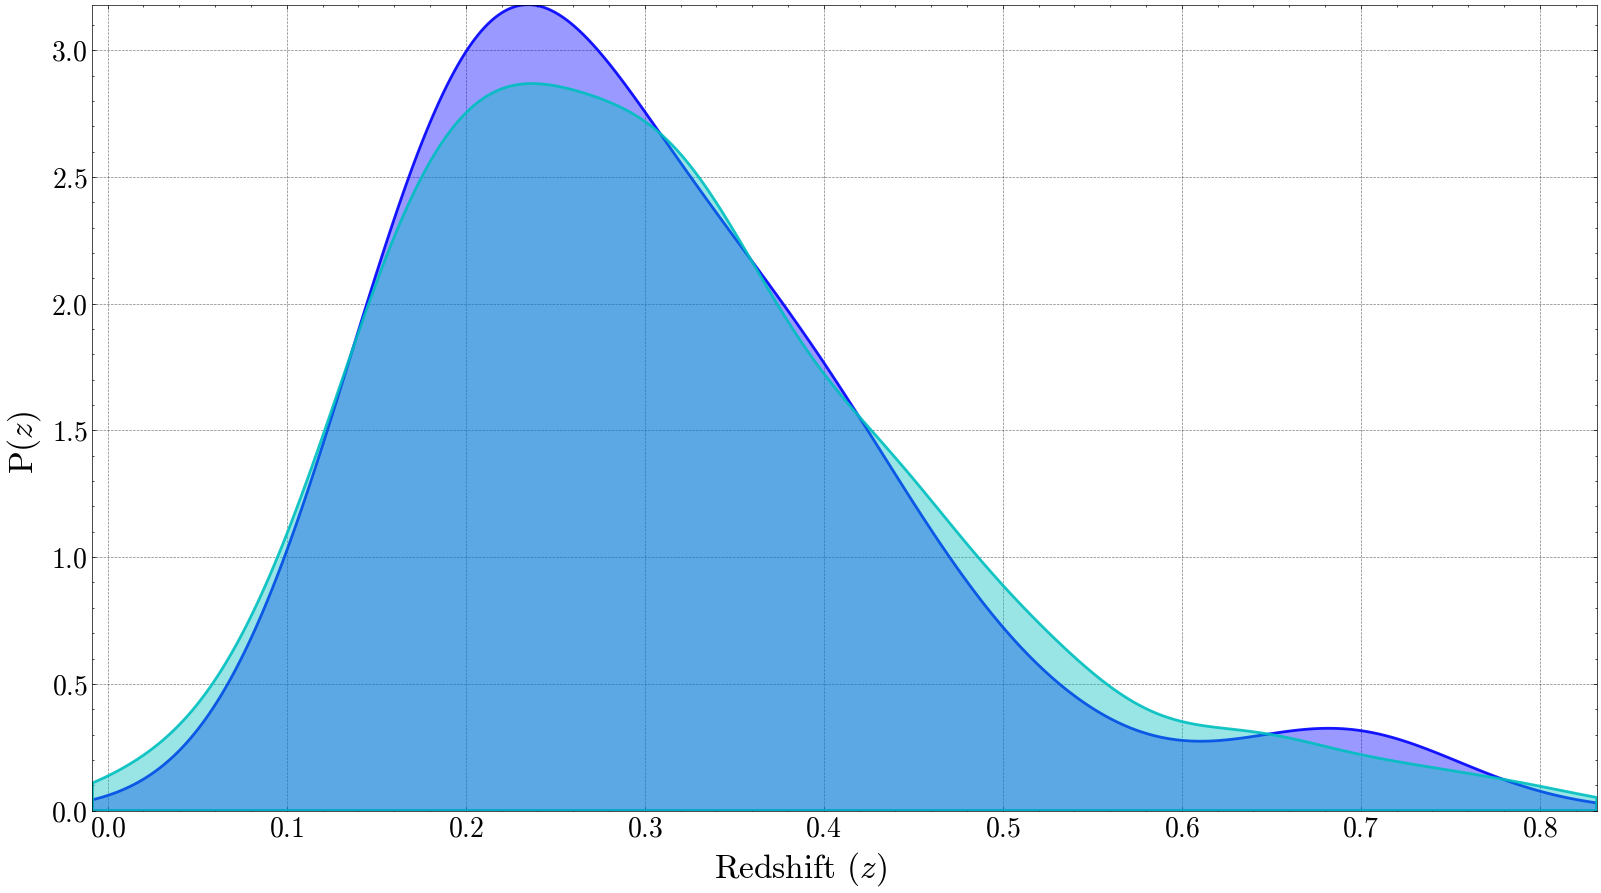

In [6]:
kernel = gaussian_kde(real_redshifts)
plot = plots.PlotDistribution(
    [real_redshifts, kernel.resample(1000)],
    y_axes=True,
    density=True,
    bins=500,
    x_labels=r'Redshift $(z)$',
    y_labels=r'${\rm P}(z)$',
    colours=['b', 'c'],
)

In [7]:
with fits.open('../data/ABELL383_F814W_drz_sci_clean.shears') as hdul:
    data = hdul[1].data

In [12]:
ra = data['ra']
dec = data['dec']
dec0 = np.mean(dec) * np.pi / 180
ra0 = np.mean(ra)
x = (ra0 - ra) * np.cos(dec0) * 3600
y = (dec - np.mean(dec)) * 3600
x = (x - np.min(x)) / (np.max(x) - np.min(x)) * shear_maps.shape[-2]
y = (y - np.min(y)) / (np.max(y) - np.min(y)) * shear_maps.shape[-1]

g1 = data['gamma1']
g2 = data['gamma2']

In [29]:
map_coordinates(shear_maps[0, 0], [x, y])

np.float64(2.76894756242207e-05)

In [47]:
def shear_to_image(x, y, shear_values, image_shape):
    # Convert coordinates to integer pixel indices
    xi = np.clip(np.round(x).astype(int), 0, image_shape[0] - 1)
    yi = np.clip(np.round(y).astype(int), 0, image_shape[1] - 1)

    # Initialize arrays for sum and count
    image_sum = np.zeros(image_shape)
    image_count = np.zeros(image_shape)

    # Accumulate shear values and counts efficiently
    np.add.at(image_sum, (xi, yi), shear_values)
    np.add.at(image_count, (xi, yi), 1)

    # Compute average, avoiding division by zero
    image_avg = np.divide(image_sum, image_count, out=np.zeros_like(image_sum), where=image_count > 0)
    return image_avg

In [111]:
new_shear = np.stack((
    shear_to_image(x, y, map_coordinates(shear_maps[0, 0], [x, y]), image_shape=(100, 100)),
    shear_to_image(x, y, map_coordinates(shear_maps[0, 1], [x, y]), image_shape=(100, 100)),
), axis=0)
new_convergence = shear_to_image(x, y, map_coordinates(images[0, 0], [x, y]), image_shape=(100, 100))

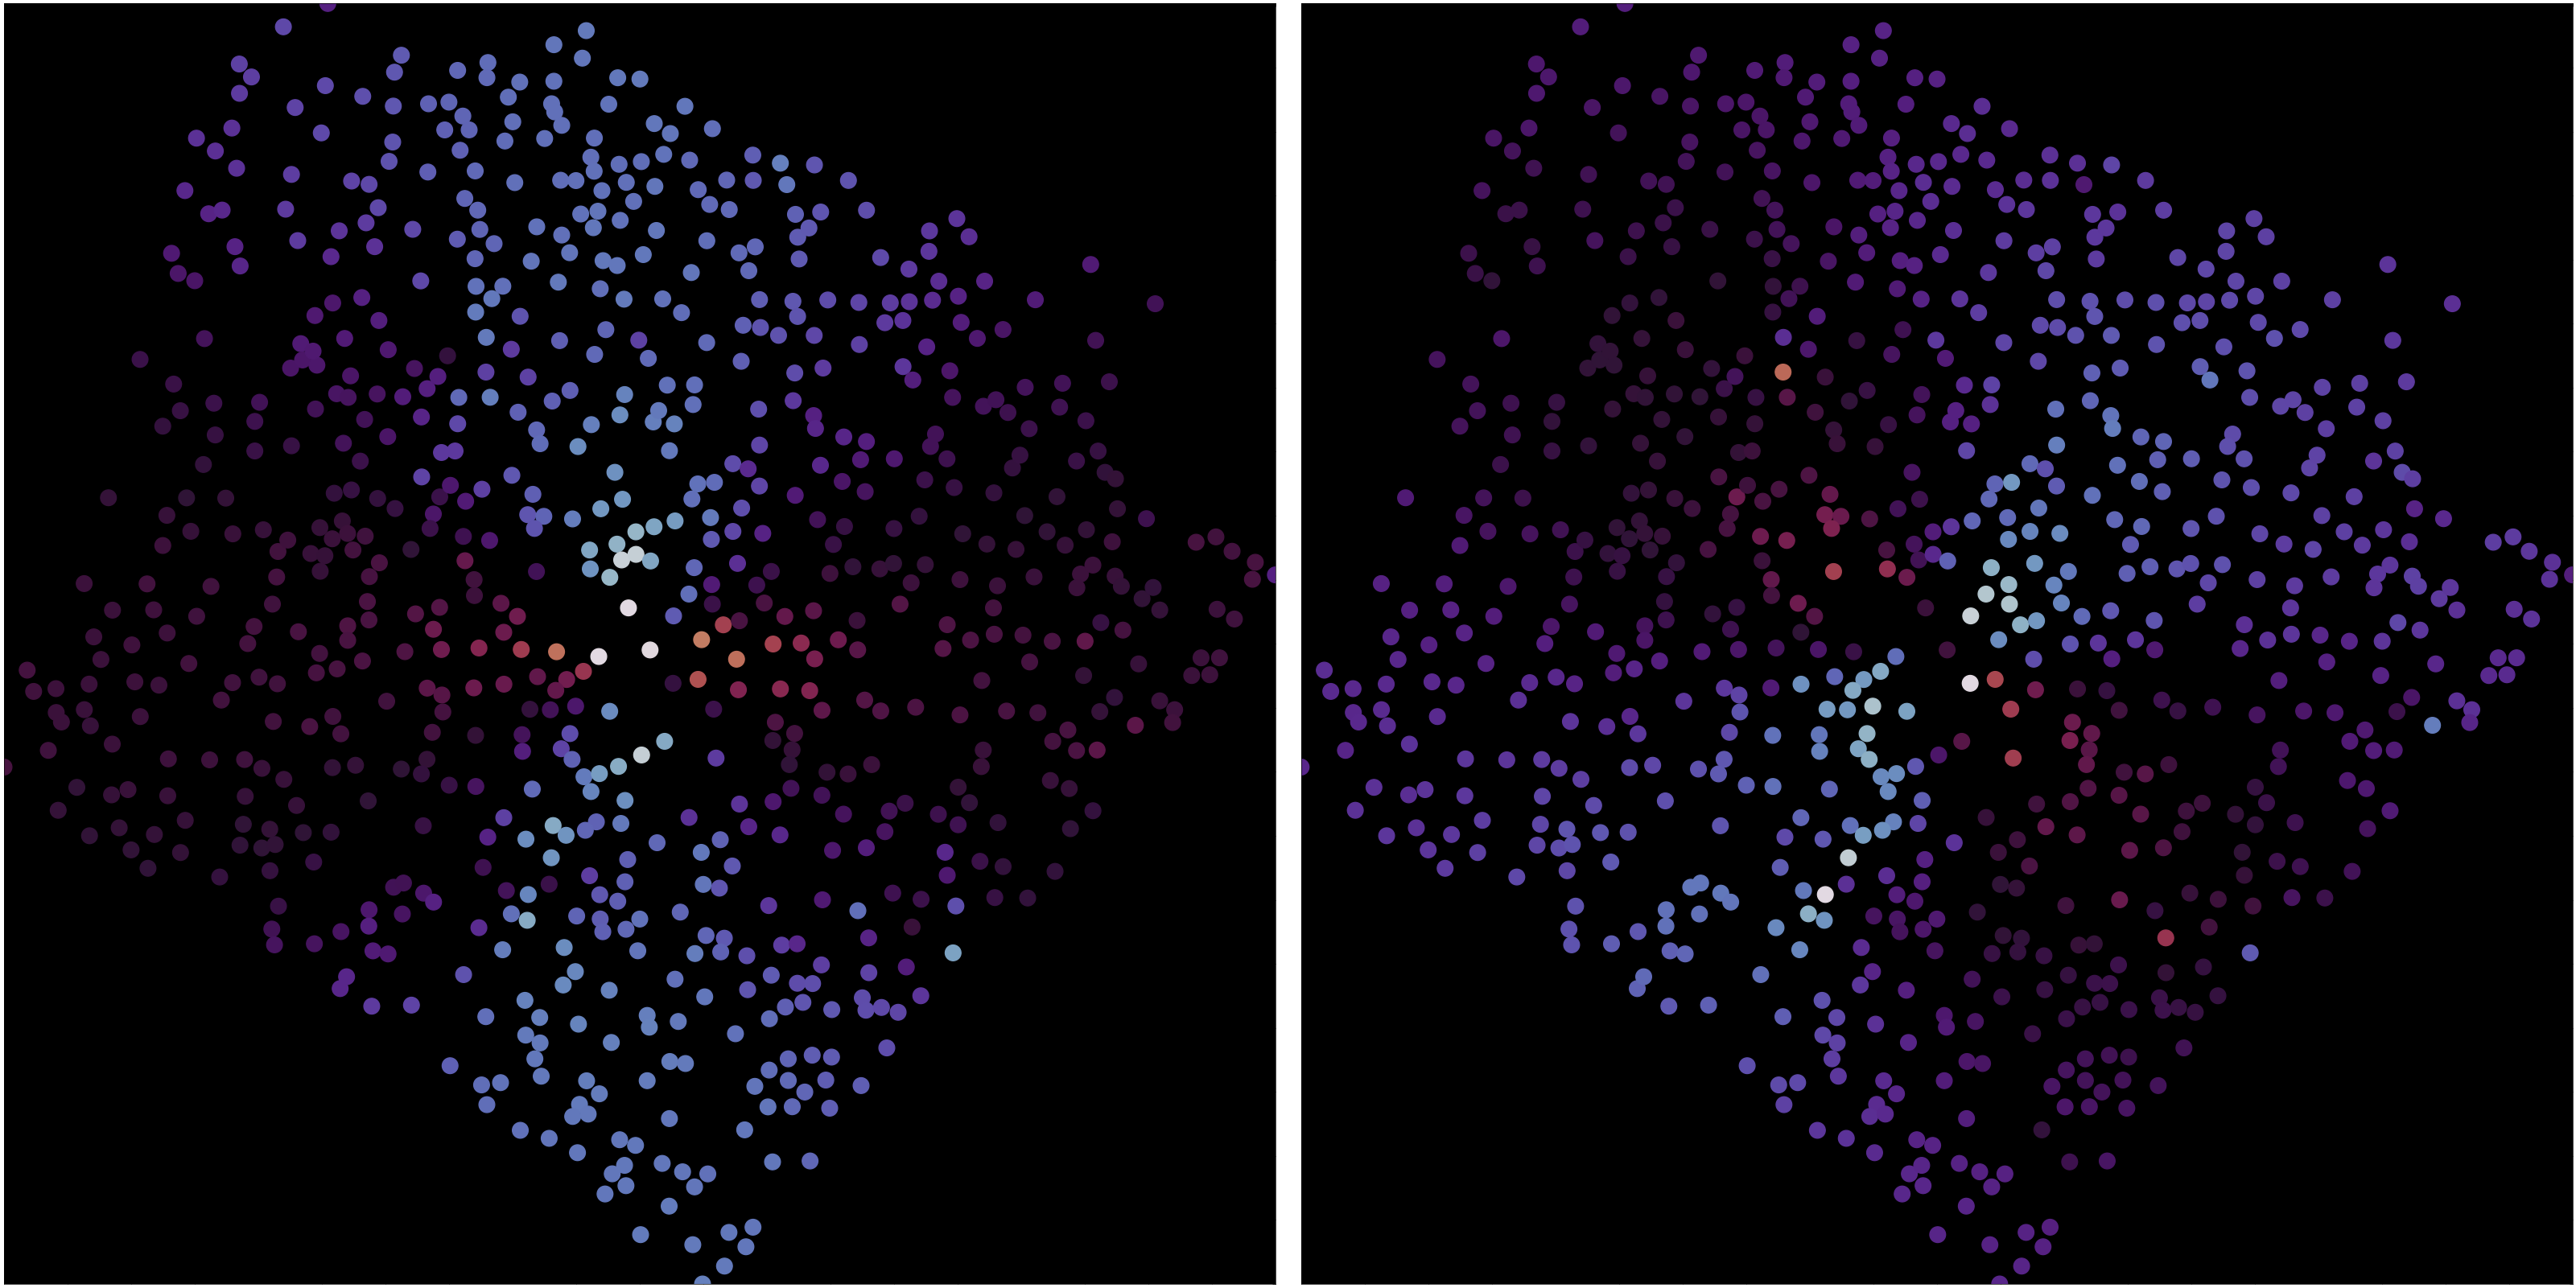

In [90]:
fig, axes = plt.subplots(1, 2, figsize=(32, 16), constrained_layout=True)
axes[0].scatter(x, y, c=map_coordinates(shear_maps[0, 0], [x, y]), cmap='twilight', s=200)
axes[1].scatter(x, y, c=map_coordinates(shear_maps[0, 1], [x, y]), cmap='twilight', s=200)
axes[0].set_xlim(0, 100)
axes[0].set_ylim(0, 100)
axes[0].set_facecolor('k')
axes[0].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
axes[1].set_xlim(0, 100)
axes[1].set_ylim(0, 100)
axes[1].set_facecolor('k')
axes[1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

In [112]:
# np.min(new_shear[0], where=new_shear[0] != 0, initial=np.inf)
new_shear = np.where(new_shear == 0, np.nan, new_shear)
# new_shear = np.where(
#     new_shear == 0,
#     0.5,
#     (new_shear - np.min(new_shear, axis=(-2, -1))[:, None, None]) / (np.max(new_shear, axis=(-2, -1))[:, None, None] - np.min(new_shear, axis=(-2, -1))[:, None, None]),
# )

In [115]:
twilight = mpl.colormaps.get_cmap('twilight')
twilight.set_bad('k')

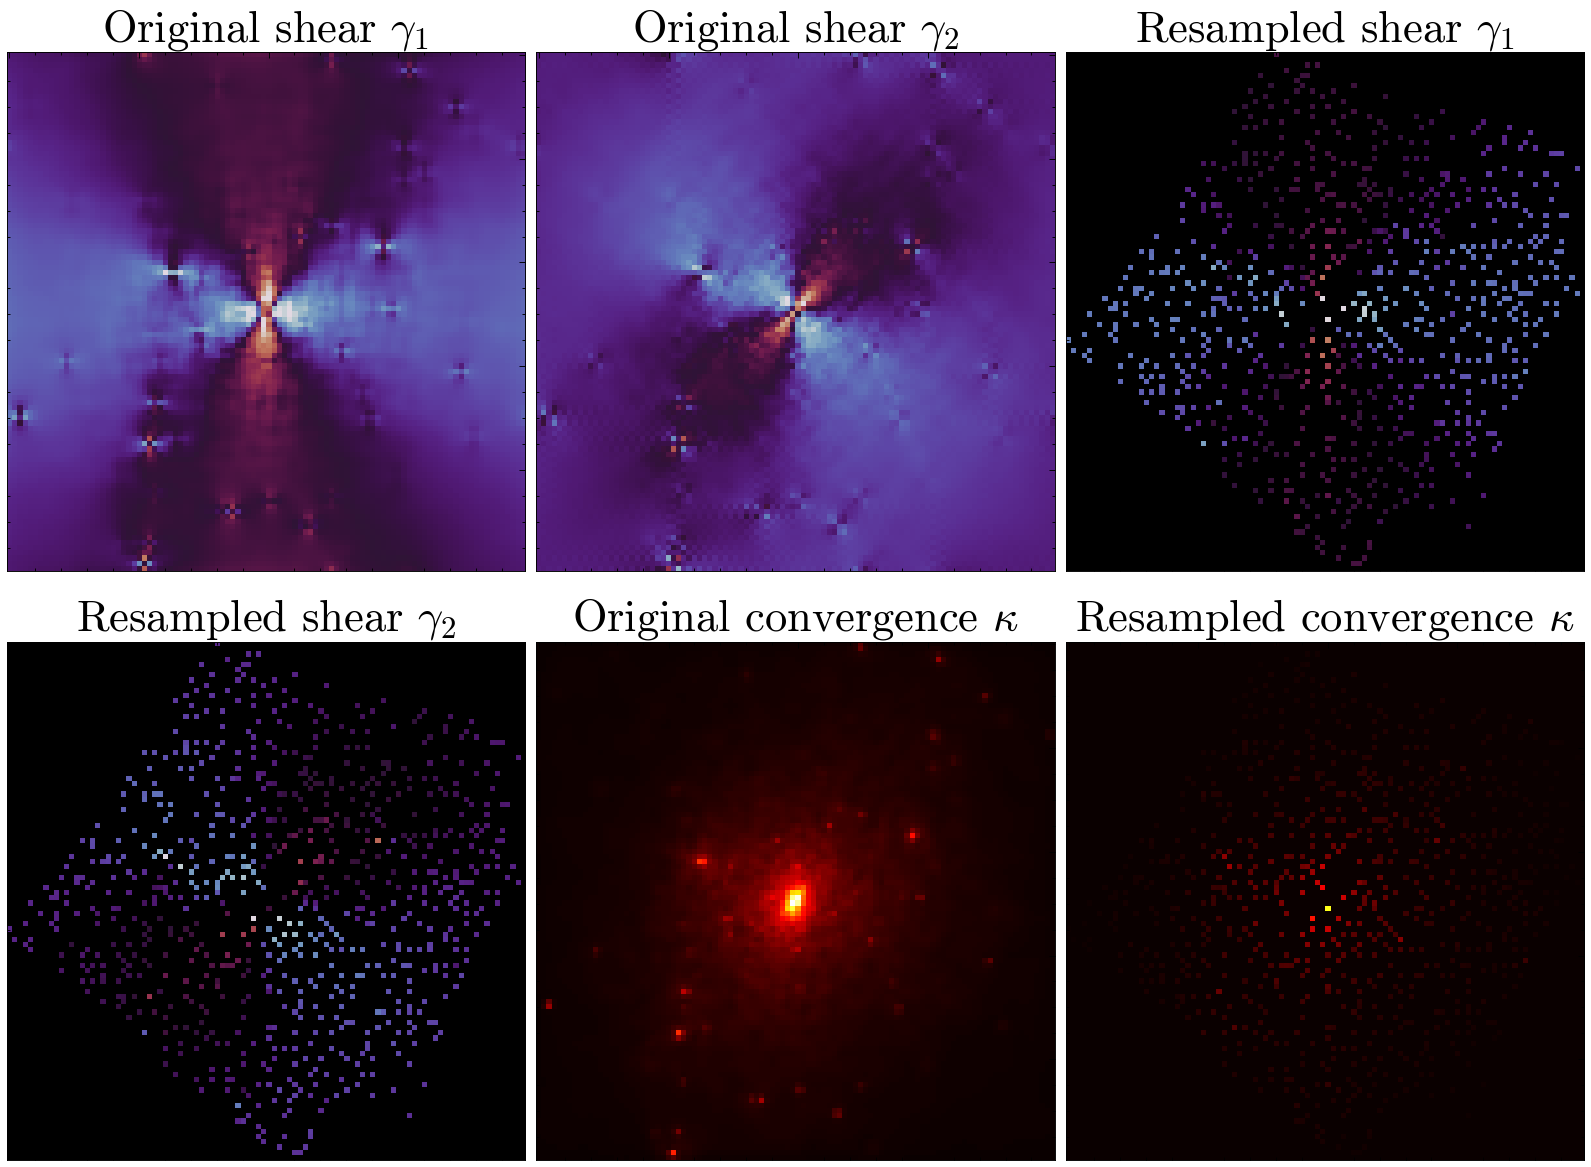

In [130]:
plot = plots.PlotImages(
    [*shear_maps[0], *new_shear, images[0, 0], new_convergence],
    titles=[
        r'Original shear $\gamma_1$',
        r'Original shear $\gamma_2$',
        r'Resampled shear $\gamma_1$',
        r'Resampled shear $\gamma_2$',
        r'Original convergence $\kappa$',
        r'Resampled convergence $\kappa$',
    ],
    cmaps=[twilight] * 4 + ['hot'] * 2,
    ranges=[
        (np.min(shear_maps[0, 0]), np.max(shear_maps[0, 0])),
        (np.min(shear_maps[0, 1]), np.max(shear_maps[0, 1])),
        (np.nanmin(new_shear[0]), np.nanmax(new_shear[0])),
        (np.nanmin(new_shear[1]), np.nanmax(new_shear[1])),
        (np.min(images[0, 0]), np.max(images[0, 0])),
        (np.min(images[0, 0]), np.max(images[0, 0])),
    ],
    fig_size=(16, 12),
)